# (2) CV WINTER 2023 - Blurred Image Detection via Supervised Learning

### Project Description
There is a dataset of images, par of which is blurred. The task is to develop a machine learning algorithm to detect whether the image is blurred or sharp on the unknown dataset.

### Data Description
The dataset consists of images, and some of them are blurred. The images are blurred using augmentation.

Data files:
- ```train``` - a folder for training
- ```test``` - a folder with images, for which we make predicitons
- ```train.csv``` - labels (answers) to the train sample: **if 1, the image is blurred.**

### Papers:
- https://jiaya.me/all_final_papers/blur_detect_cvpr08.pdf
- https://fled.github.io/paper/blur.pdf
- http://graphics.im.ntu.edu.tw/docs/mmm08.pdf


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

from keras.preprocessing import image
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter("ignore")

# show the version of tf
print(cv2.__version__)

4.7.0


## 1 Data Load

### 1.1 Loading images and labels from given datasets

In [13]:
labels = pd.read_csv('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/train.csv')
labels.head()

,filename,blur
0,kagouracdzwrjjxzzedi.jpg,0.0
1,ahnamimqdfqoqdnozabc.jpg,0.0
2,gwhdadvghuzinmzhzssx.jpg,0.0
3,onqwabwwckubrydgbzly.jpg,0.0
4,ewpqdruddbokqyzzupcw.jpg,1.0


In [14]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2
)

validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

# Чтобы загрузчик извлёк данные из папки, вызовем функцию 
# flow_from_directory() (англ. «поток из директории»):

train_datagen_flow = train_datagen.flow_from_directory(
    '/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    seed=12345)

val_datagen_flow = validation_datagen.flow_from_directory(
    '/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    seed=12345)

Found 2579 images belonging to 2 classes.
Found 859 images belonging to 2 classes.


### 1.2 Exploratory Data Analysis

#### 1.2.1 Understanding the variables type, labels structure, number of target classes.

In [15]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664 entries, 0 to 2663
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  2664 non-null   object 
 1   blur      2664 non-null   float64
dtypes: float64(1), object(1)
memory usage: 41.8+ KB


In [16]:
labels['blur'].unique()

array([0., 1.])

In [17]:
print(len(labels))

2664


#### 1.2.2 Descriptive statistics of labels

In [18]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
blur,2664.0,0.486862,0.499921,0.0,0.0,0.0,1.0,1.0


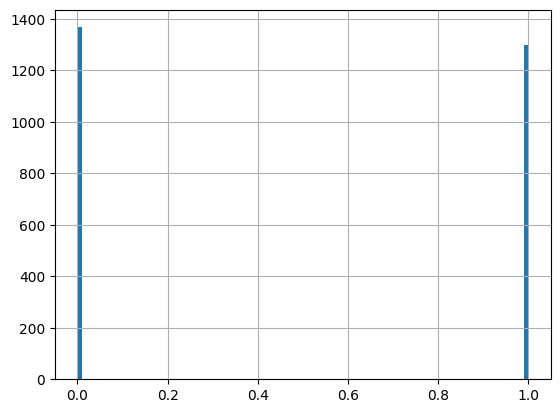

In [19]:
labels['blur'].hist(bins=100);

#### 1.2.3 Checking the target value for missing and duplicates

In [20]:
labels.isna().sum()

filename    0
blur        0
dtype: int64

In [21]:
labels.duplicated().sum()

0

#### 1.2.4  Checking the target value for disbalance

In [22]:
labels_df = pd.DataFrame(labels)

In [23]:
labels_df['blur'].value_counts()

0.0    1367
1.0    1297
Name: blur, dtype: int64

In [24]:
train_blur = labels[labels["blur"]==1]
train_sharp = labels[labels["blur"]==0]

print("Blur images:", len(train_blur))
print("Sharp images:", len(train_sharp))

Blur images: 1297
Sharp images: 1367


In [103]:
img = Image.open('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/train/train/aaashhimmhraddpwwizz.jpg')
img

NameError: name 'Image' is not defined

### ***Examples of sharp image***

In [ ]:
images = train_sharp.filename.sample(10).tolist()
plot_images(images, 
            max_images=10,
            img_width=220,
            force_b64=True)

### ***Examples of blurred images***

In [ ]:
images = train_blur.filename.sample(10).tolist()
plot_images(images,
            max_images=10,
            img_width=220,
            force_b64=True)

### ***Conclusion:*** Type of variable in the target values is ```float64``` with two unique values - 0, 1. This is fine for solving classification problem, but the target should be converted into ```string``` type. Number of observations if 2664. The target dataset is balanced.

## 2 Constructing CNN models

In [25]:
path = '/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/'

In [26]:
def load_train(path):
    labels = pd.read_csv(path + 'train.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'train/train/',
        x_col='filename',
        y_col='blur',
        target_size=(96, 96),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=5)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'train.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'train/train/',
        x_col='filename',
        y_col='blur',
        target_size=(96, 96),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=5)

    return test_gen_flow

In [27]:
train = load_train(path)

Found 1998 validated image filenames.


In [28]:
valid = load_test(path)

Found 666 validated image filenames.


In [29]:
from tensorflow.keras.applications.resnet import ResNet50

In [31]:
def create_model(input_shape):
    model = Sequential()
#     model.add(layers.Reshape((96, 96, 2), input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
#     model.add(BatchNormalization())
    model.add(Flatten())    
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
#     model.add(BatchNormalization())
    model.add(Dense(1, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.0001)
    
    model.compile(optimizer, loss = "categorical_crossentropy",
                  metrics=['accuracy'])
    return model

In [39]:
# def train_model(model, train_data, test_data, batch_size=None, epochs=30,
#                 steps_per_epoch=None, validation_steps=None):

#     if steps_per_epoch is None:
#         steps_per_epoch = len(train_data)
#     if validation_steps is None:
#         validation_steps = len(test_data)

#     model.fit(train_data,
#               validation_data=test_data,
#               batch_size=batch_size,
#               epochs=epochs,
#               steps_per_epoch=steps_per_epoch,
#               validation_steps=validation_steps,
#               verbose=2)

#     return model

In [40]:
input_shape = (96, 96, 3)

In [42]:
STEP_SIZE_TRAIN=train.n//train.batch_size
STEP_SIZE_VALID=valid.n//valid.batch_size

- Model 1

In [41]:
# Initiating the model
model = create_model(input_shape)

In [43]:
# %%time
# # training the model
# history = train_model(model, 
#                         train,
#                         valid, 
#                         batch_size=5, 
#                         epochs=5, 
#                         steps_per_epoch=STEP_SIZE_TRAIN, 
#                         validation_steps=STEP_SIZE_VALID)

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        1792      
                                                                 
 activation_3 (Activation)   (None, 96, 96, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        18464     
                                                                 
 activation_4 (Activation)   (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 47, 47, 32)        0         
                                                      

In [46]:
%%time
history = model.fit_generator(train,
          validation_data=valid,
          epochs=30,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/10
62/62 - 63s - loss: 0.0000e+00 - accuracy: 0.4863 - val_loss: 0.0000e+00 - val_accuracy: 0.4922 - 63s/epoch - 1s/step
Epoch 2/10
62/62 - 66s - loss: 0.0000e+00 - accuracy: 0.4842 - val_loss: 0.0000e+00 - val_accuracy: 0.4906 - 66s/epoch - 1s/step
Epoch 3/10
62/62 - 63s - loss: 0.0000e+00 - accuracy: 0.4852 - val_loss: 0.0000e+00 - val_accuracy: 0.4953 - 63s/epoch - 1s/step
Epoch 4/10
62/62 - 60s - loss: 0.0000e+00 - accuracy: 0.4839 - val_loss: 0.0000e+00 - val_accuracy: 0.4922 - 60s/epoch - 975ms/step
Epoch 5/10
62/62 - 63s - loss: 0.0000e+00 - accuracy: 0.4863 - val_loss: 0.0000e+00 - val_accuracy: 0.4906 - 63s/epoch - 1s/step
Epoch 6/10
62/62 - 62s - loss: 0.0000e+00 - accuracy: 0.4852 - val_loss: 0.0000e+00 - val_accuracy: 0.4891 - 62s/epoch - 998ms/step
Epoch 7/10
62/62 - 63s - loss: 0.0000e+00 - accuracy: 0.4822 - val_loss: 0.0000e+00 - val_accuracy: 0.4844 - 63s/epoch - 1s/step
Epoch 8/10
62/62 - 65s - loss: 0.0000e+00 - accuracy: 0.4842 - val_loss: 0.0000e+00 - val_a

- Model 2

In [78]:
def create_model_ResNet50(input_shape):    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    
#     замораживаем ResNet50 без верхушки
#     backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
#     model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='softmax')) 

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss = "binary_crossentropy",
                  metrics=['accuracy'])

    return model

In [79]:
# Initiating the model
model2 = create_model_ResNet50(input_shape)

In [80]:
# %%time
# # training the model
# history2 = train_model(model2, 
#                              train, 
#                              valid, 
#                              batch_size=5, 
#                              epochs=5, 
#                              steps_per_epoch=None, 
#                              validation_steps=None)

In [81]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_13 (Dense)            (None, 32)                65568     
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 23,653,313
Trainable params: 23,600,193
Non-trainable params: 53,120
_____________________________________

In [82]:
%%time
history2 = model2.fit_generator(train,
          validation_data=valid,
          epochs=10,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/10
62/62 - 311s - loss: 0.6489 - accuracy: 0.4852 - val_loss: 0.6946 - val_accuracy: 0.4984 - 311s/epoch - 5s/step
Epoch 2/10
62/62 - 276s - loss: 0.2723 - accuracy: 0.4863 - val_loss: 2.0033 - val_accuracy: 0.4906 - 276s/epoch - 4s/step
Epoch 3/10
62/62 - 396s - loss: 0.1968 - accuracy: 0.4852 - val_loss: 0.6918 - val_accuracy: 0.4906 - 396s/epoch - 6s/step
Epoch 4/10
62/62 - 261s - loss: 0.1485 - accuracy: 0.4827 - val_loss: 1.4749 - val_accuracy: 0.5000 - 261s/epoch - 4s/step
Epoch 5/10
62/62 - 262s - loss: 0.1094 - accuracy: 0.4847 - val_loss: 3.5261 - val_accuracy: 0.4938 - 262s/epoch - 4s/step
Epoch 6/10
62/62 - 263s - loss: 0.0962 - accuracy: 0.4847 - val_loss: 0.8395 - val_accuracy: 0.4938 - 263s/epoch - 4s/step
Epoch 7/10
62/62 - 259s - loss: 0.1016 - accuracy: 0.4852 - val_loss: 0.6369 - val_accuracy: 0.4938 - 259s/epoch - 4s/step
Epoch 8/10
62/62 - 264s - loss: 0.0665 - accuracy: 0.4837 - val_loss: 0.5900 - val_accuracy: 0.4984 - 264s/epoch - 4s/step
Epoch 9/10
62/62

- Model 3

In [85]:
# Ruba's CNN
def create_model_3(input_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(2, 2), activation ='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization()) # added
    model.add(Conv2D(64, kernel_size = (2,2), activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization()) # added
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0001) # updated to lr=0.0001

    model.compile(loss = "binary_crossentropy", 
              optimizer=optimizer, metrics=['accuracy'])
    return model

In [86]:
# Initiating the model
model3 = create_model_3(input_shape)

In [87]:
# # training the model
# model_3 = train_model(model_3, 
#                         train,
#                         valid, 
#                         batch_size=32, 
#                         epochs=50, 
#                         steps_per_epoch=STEP_SIZE_TRAIN, 
#                         validation_steps=STEP_SIZE_VALID)

In [88]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        1792      
                                                                 
 activation_3 (Activation)   (None, 96, 96, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        18464     
                                                                 
 activation_4 (Activation)   (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 47, 47, 32)        0         
                                                      

In [89]:
%%time
history3 = model3.fit_generator(train,
          validation_data=valid,
          epochs=30,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/30
62/62 - 26s - loss: 0.7153 - accuracy: 0.6506 - val_loss: 0.7227 - val_accuracy: 0.4875 - 26s/epoch - 421ms/step
Epoch 2/30
62/62 - 22s - loss: 0.4453 - accuracy: 0.8098 - val_loss: 0.7172 - val_accuracy: 0.5469 - 22s/epoch - 357ms/step
Epoch 3/30
62/62 - 22s - loss: 0.3542 - accuracy: 0.8484 - val_loss: 0.7319 - val_accuracy: 0.5609 - 22s/epoch - 358ms/step
Epoch 4/30
62/62 - 22s - loss: 0.2935 - accuracy: 0.8866 - val_loss: 0.7075 - val_accuracy: 0.6000 - 22s/epoch - 358ms/step
Epoch 5/30
62/62 - 22s - loss: 0.2543 - accuracy: 0.8952 - val_loss: 1.0312 - val_accuracy: 0.5813 - 22s/epoch - 361ms/step
Epoch 6/30
62/62 - 22s - loss: 0.2124 - accuracy: 0.9207 - val_loss: 1.0157 - val_accuracy: 0.6094 - 22s/epoch - 356ms/step
Epoch 7/30
62/62 - 22s - loss: 0.1980 - accuracy: 0.9288 - val_loss: 1.3019 - val_accuracy: 0.5828 - 22s/epoch - 355ms/step
Epoch 8/30
62/62 - 22s - loss: 0.1816 - accuracy: 0.9359 - val_loss: 0.9672 - val_accuracy: 0.6594 - 22s/epoch - 356ms/step
Epoch 9/

- Model 4

In [91]:
def create_model_4(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3),
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization()) # added
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001) # updated to lr=0.0001
    model.compile(optimizer=optimizer, 
                  loss="binary_crossentropy", 
              metrics=["accuracy"])
    return model

In [92]:
%%time
# Initiating the model
model4 = create_model_4(input_shape)

# # training the model
# model_4 = train_model(model_4, 
#                         train,
#                         valid, 
#                         batch_size=16, 
#                         epochs=3, 
#                         steps_per_epoch=STEP_SIZE_TRAIN, 
#                         validation_steps=STEP_SIZE_VALID)

CPU times: user 117 ms, sys: 4.95 ms, total: 122 ms
Wall time: 124 ms


In [93]:
model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 activation_8 (Activation)   (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 47, 47, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 activation_9 (Activation)   (None, 45, 45, 64)        0         
                                                      

In [95]:
%%time
history4 = model4.fit_generator(train,
          validation_data=valid,
          epochs=30,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/30
62/62 - 28s - loss: 0.7997 - accuracy: 0.4873 - val_loss: 0.6860 - val_accuracy: 0.4922 - 28s/epoch - 452ms/step
Epoch 2/30
62/62 - 26s - loss: 0.7100 - accuracy: 0.4863 - val_loss: 0.6785 - val_accuracy: 0.4922 - 26s/epoch - 415ms/step
Epoch 3/30
62/62 - 27s - loss: 0.6462 - accuracy: 0.4827 - val_loss: 0.6596 - val_accuracy: 0.4922 - 27s/epoch - 431ms/step
Epoch 4/30
62/62 - 27s - loss: 0.6249 - accuracy: 0.4827 - val_loss: 0.6506 - val_accuracy: 0.4953 - 27s/epoch - 434ms/step
Epoch 5/30
62/62 - 26s - loss: 0.5948 - accuracy: 0.4863 - val_loss: 0.6283 - val_accuracy: 0.4953 - 26s/epoch - 423ms/step
Epoch 6/30
62/62 - 27s - loss: 0.5670 - accuracy: 0.4863 - val_loss: 0.6220 - val_accuracy: 0.4875 - 27s/epoch - 436ms/step
Epoch 7/30
62/62 - 26s - loss: 0.5297 - accuracy: 0.4847 - val_loss: 0.6386 - val_accuracy: 0.4891 - 26s/epoch - 422ms/step
Epoch 8/30
62/62 - 27s - loss: 0.5024 - accuracy: 0.4863 - val_loss: 0.8022 - val_accuracy: 0.4922 - 27s/epoch - 437ms/step
Epoch 9/

- Model 5

In [104]:
def create_model_5(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization()) # added
#     model.add(Conv2D(64, (3, 3), padding='same'))
#     model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25)) # regularization
    model.add(BatchNormalization()) # added
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adamax', 
                  loss="binary_crossentropy", 
              metrics=["accuracy"])
    return model

In [99]:
# Initiating the model
model5 = create_model_5(input_shape)

# # training the model
# model5 = train_model(model_5, 
#                         train,
#                         valid, 
#                         batch_size=32, 
#                         epochs=50, 
#                         steps_per_epoch=STEP_SIZE_TRAIN, 
#                         validation_steps=STEP_SIZE_VALID)

In [100]:
model5.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 activation_10 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 94, 94, 32)        9248      
                                                                 
 activation_11 (Activation)  (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 47, 47, 32)        0         
                                                     

In [101]:
%%time
history5 = model5.fit_generator(train,
          validation_data=valid,
          epochs=30,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/30
62/62 - 50s - loss: 0.8692 - accuracy: 0.5941 - val_loss: 0.6823 - val_accuracy: 0.5469 - 50s/epoch - 806ms/step
Epoch 2/30
62/62 - 50s - loss: 0.6595 - accuracy: 0.7019 - val_loss: 0.6917 - val_accuracy: 0.5125 - 50s/epoch - 803ms/step
Epoch 3/30
62/62 - 51s - loss: 0.5049 - accuracy: 0.7721 - val_loss: 1.1316 - val_accuracy: 0.5078 - 51s/epoch - 822ms/step
Epoch 4/30
62/62 - 52s - loss: 0.5233 - accuracy: 0.7803 - val_loss: 1.9019 - val_accuracy: 0.5000 - 52s/epoch - 845ms/step
Epoch 5/30
62/62 - 51s - loss: 0.4122 - accuracy: 0.8286 - val_loss: 2.1359 - val_accuracy: 0.5094 - 51s/epoch - 816ms/step
Epoch 6/30
62/62 - 48s - loss: 0.4112 - accuracy: 0.8316 - val_loss: 1.6988 - val_accuracy: 0.5047 - 48s/epoch - 778ms/step
Epoch 7/30
62/62 - 49s - loss: 0.3627 - accuracy: 0.8555 - val_loss: 1.5873 - val_accuracy: 0.5172 - 49s/epoch - 787ms/step
Epoch 8/30
62/62 - 50s - loss: 0.3486 - accuracy: 0.8571 - val_loss: 1.3430 - val_accuracy: 0.5437 - 50s/epoch - 803ms/step
Epoch 9/

In [114]:
%%time
history6 = model5.fit_generator(train,
          validation_data=valid,
          epochs=50,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/50
62/62 - 48s - loss: 0.1335 - accuracy: 0.9471 - val_loss: 0.4296 - val_accuracy: 0.8313 - 48s/epoch - 771ms/step
Epoch 2/50
62/62 - 47s - loss: 0.1329 - accuracy: 0.9466 - val_loss: 0.4535 - val_accuracy: 0.8828 - 47s/epoch - 751ms/step
Epoch 3/50
62/62 - 47s - loss: 0.1291 - accuracy: 0.9481 - val_loss: 0.3177 - val_accuracy: 0.8922 - 47s/epoch - 757ms/step
Epoch 4/50
62/62 - 46s - loss: 0.1158 - accuracy: 0.9603 - val_loss: 0.4513 - val_accuracy: 0.8609 - 46s/epoch - 749ms/step
Epoch 5/50
62/62 - 48s - loss: 0.1163 - accuracy: 0.9598 - val_loss: 0.3251 - val_accuracy: 0.8750 - 48s/epoch - 776ms/step
Epoch 6/50
62/62 - 47s - loss: 0.1260 - accuracy: 0.9563 - val_loss: 0.3642 - val_accuracy: 0.8813 - 47s/epoch - 751ms/step
Epoch 7/50
62/62 - 47s - loss: 0.1121 - accuracy: 0.9552 - val_loss: 0.3994 - val_accuracy: 0.8531 - 47s/epoch - 755ms/step
Epoch 8/50
62/62 - 50s - loss: 0.1305 - accuracy: 0.9486 - val_loss: 0.3404 - val_accuracy: 0.8938 - 50s/epoch - 807ms/step
Epoch 9/

In [ ]:
%%time
history7 = model5.fit_generator(train,
          validation_data=valid,
          epochs=100,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=1)

Epoch 1/100
62/62 [==============================] - 47s 760ms/step - loss: 0.0631 - accuracy: 0.9786 - val_loss: 0.3663 - val_accuracy: 0.9000
Epoch 2/100
62/62 [==============================] - 47s 755ms/step - loss: 0.0452 - accuracy: 0.9832 - val_loss: 0.6197 - val_accuracy: 0.8313
Epoch 3/100
62/62 [==============================] - 47s 759ms/step - loss: 0.0504 - accuracy: 0.9814 - val_loss: 0.4083 - val_accuracy: 0.8875
Epoch 4/100
62/62 [==============================] - 47s 761ms/step - loss: 0.0919 - accuracy: 0.9664 - val_loss: 0.4574 - val_accuracy: 0.8813
Epoch 5/100
62/62 [==============================] - 47s 762ms/step - loss: 0.0401 - accuracy: 0.9868 - val_loss: 0.5092 - val_accuracy: 0.8875
Epoch 6/100
62/62 [==============================] - 49s 781ms/step - loss: 0.0517 - accuracy: 0.9829 - val_loss: 0.3798 - val_accuracy: 0.8734
Epoch 7/100
62/62 [==============================] - 53s 853ms/step - loss: 0.0504 - accuracy: 0.9791 - val_loss: 0.3734 - val_accuracy:

## 3 Choosing the best CNN model

In [ ]:
plt.plot(history.history['val_loss'], 'r', 
         history2.history['val_loss'], 'g', 
         history3.history['val_loss'], 'darkred', 
         history4.history['val_loss'], 'orange', 
         history5.history['val_loss'], 'b');

In [ ]:
plt.plot(history5.history['val_loss'], 'b',
         history6.history['val_loss'], 'cyan',
         history7.history['val_loss'], 'pink');

- **Model 1 - CNN**

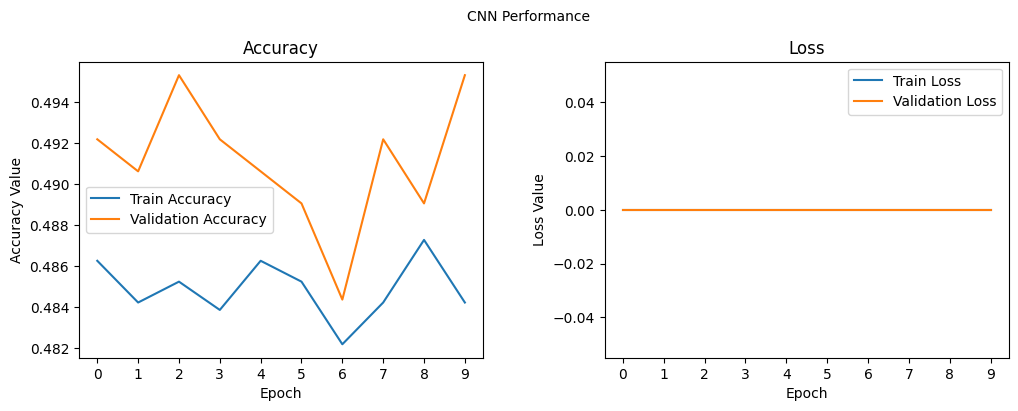

In [109]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=10)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 10))

ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 10, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 10, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [110]:
# plt.plot(history.history['accuracy'], label='acc', color='red')
# plt.plot(history.history['val_accuracy'], label='val_acc', color='darkblue')
# plt.legend();

- **Model 2 - ResNet50**

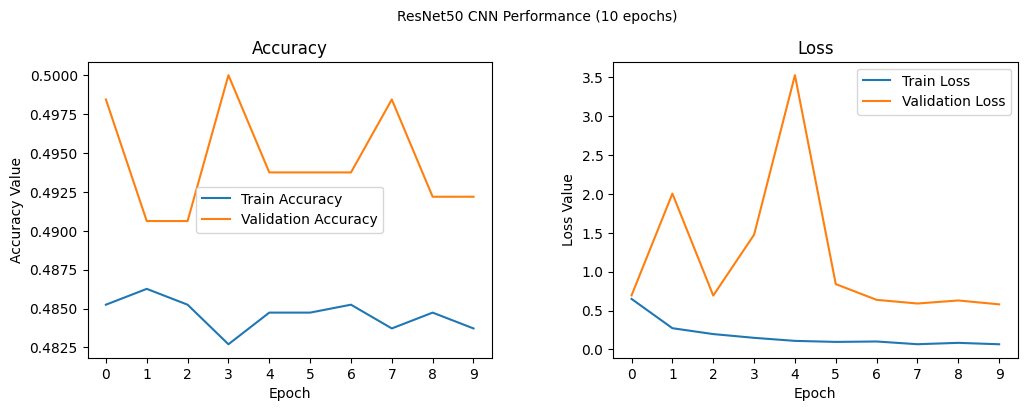

In [111]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('ResNet50 CNN Performance (10 epochs)', fontsize=10)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 10))
ax1.plot(epoch_list, history2.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history2.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 10, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history2.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 10, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

- **Model 3 - CNN**

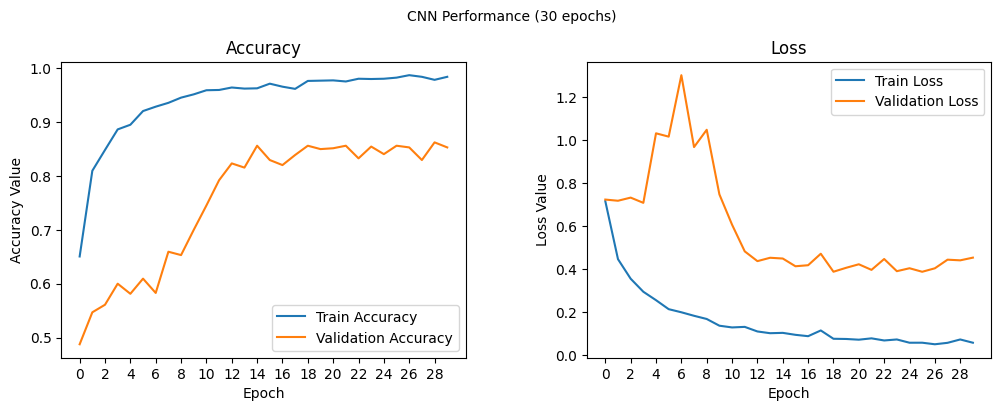

In [112]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN #5 Performance (30 epochs)', fontsize=10)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 30))
ax1.plot(epoch_list, history3.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history3.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 30, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history3.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history3.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

- **Model 4 CNN**

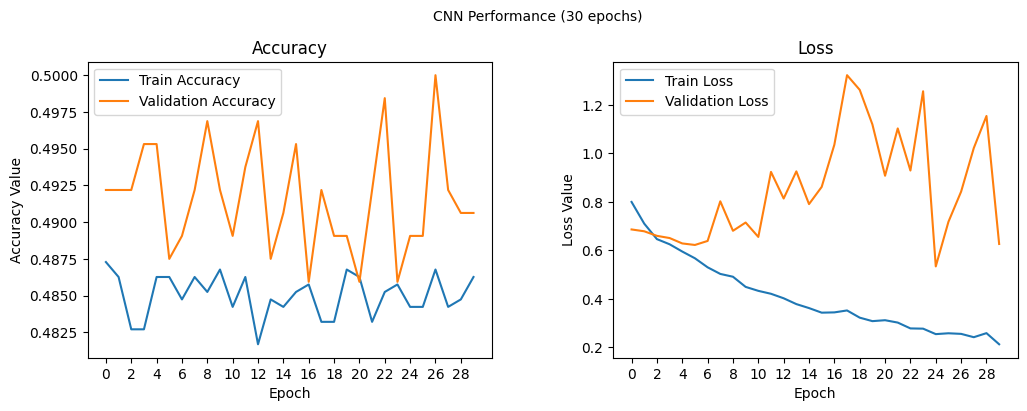

In [113]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN #4 Performance (30 epochs)', fontsize=10)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 30))
ax1.plot(epoch_list, history4.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history4.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 30, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history4.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history4.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

- **Model 5 CNN**

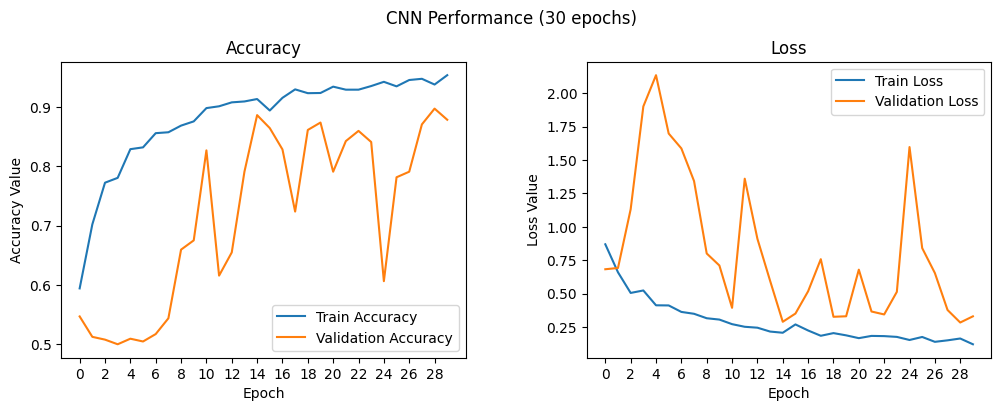

In [108]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN #5 Performance (30 epochs)', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 30))
ax1.plot(epoch_list, history5.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history5.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 30, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history5.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history5.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

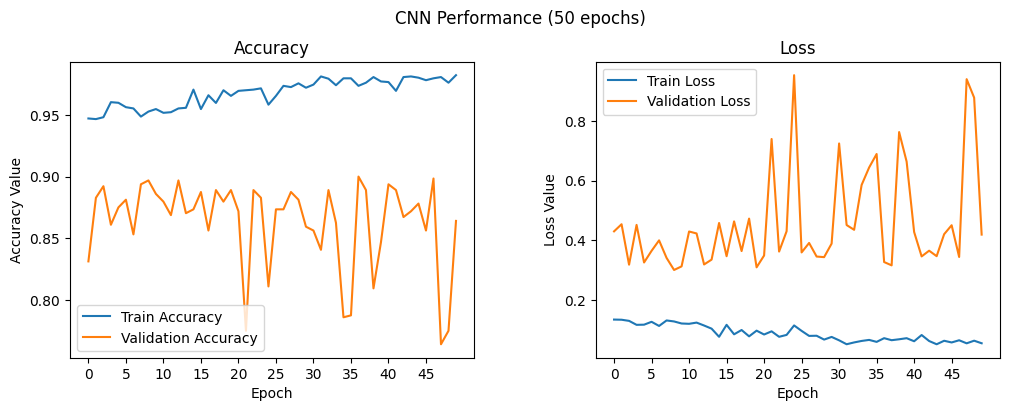

In [116]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN #5 Performance (50 epochs)', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 50))
ax1.plot(epoch_list, history6.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history6.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 50, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history6.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history6.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 50, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")